In [1]:
# !pip install torch
# !pip install transformers

In [2]:
import json
import os
import random
import re
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, DistilBertForSequenceClassification, AdamW
from torch.nn.utils.rnn import pad_sequence
from torch.cuda.amp import autocast, GradScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [51]:
file_paths = ["dataset.json"]

dataset = []

for file_path in file_paths:
    with open(file_path, "r") as file:
        data = json.load(file)

random.shuffle(data)
len(data)

47136

In [52]:
dataset = []

for i in range(0, len(data)):
    item = data[i].copy()
    item.pop('judgments', None)
    dataset.append(item)

for i in range(0, len(dataset)):
  dataset[i]['evidences'] = dataset[i]['evidences'][0].get('snippet')

dataset[0]

{'pred': '/people/deceased_person/place_of_death',
 'sub': 'Huseyn Javid',
 'obj': 'Far East',
 'evidences': "His arrest was a part of the nation-wide campaign of purge against intelligentsia. The Soviet government exiled Huseyn Javid to the Far East, where he died on 5 December 1941 in the city of Magadan. Huseyn Javid was officially exonerated in 1956. His repatriation came only on Javid's 100th birthday in 1982, when his remains were moved from Magadan back to his homeland of Nakhchivan and reburied in a mausoleum built in Javid's honor."}

In [53]:
map_pred2label ={
    '/people/person/education./education/education/institution': "educated in",
    '/people/deceased_person/place_of_death': "died in",
    '/people/person/place_of_birth': "born in",
    '/people/person/date_of_birth': "born on",
    '/people/person/education./education/education/degree': "has degree"
}

for i in range(0, len(dataset)):
  dataset[i]['pred'] = map_pred2label[dataset[i]['pred']]

dataset[0]

{'pred': 'died in',
 'sub': 'Huseyn Javid',
 'obj': 'Far East',
 'evidences': "His arrest was a part of the nation-wide campaign of purge against intelligentsia. The Soviet government exiled Huseyn Javid to the Far East, where he died on 5 December 1941 in the city of Magadan. Huseyn Javid was officially exonerated in 1956. His repatriation came only on Javid's 100th birthday in 1982, when his remains were moved from Magadan back to his homeland of Nakhchivan and reburied in a mausoleum built in Javid's honor."}

In [54]:

preds = []
for i in range(0,len(dataset)):
  for key, value in dataset[i].items():
    if key == "pred" and value not in preds:
      preds.append(value)

print(preds)


# count the number of data points related to each attribute
pred_counts = Counter(entry['pred'] for entry in dataset)
print(pred_counts)

['died in', 'born in', 'educated in', 'has degree', 'born on']
Counter({'educated in': 31991, 'born in': 8389, 'died in': 2745, 'born on': 2282, 'has degree': 1729})


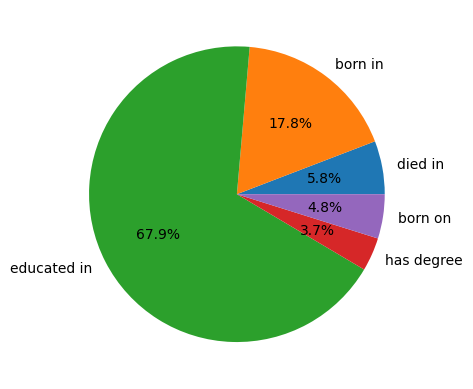

In [55]:
pie_chart = plt.pie(pred_counts.values(), labels= preds, autopct='%1.1f%%')
plt.show(pie_chart)

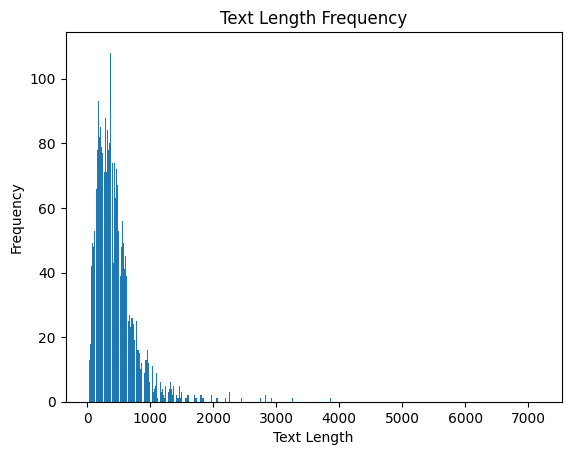

In [56]:
for data in dataset:
  data['text_length'] = len(data['evidences'])

length_frequency = Counter(entry['text_length'] for entry in dataset)

# Extract lengths and frequencies for plotting
lengths = list(length_frequency.keys())
frequencies = list(length_frequency.values())

# Plotting
plt.bar(lengths, frequencies)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Frequency')
plt.show()

In [57]:
# filter the dataset based on the text length
for data in dataset:
  if data['text_length'] > 600 or data['text_length'] < 20:
    dataset.remove(data)

len(dataset)

38133

In [58]:
Counter(data['pred'] for data in dataset)

Counter({'died in': 2368,
         'born in': 7278,
         'educated in': 25081,
         'has degree': 1416,
         'born on': 1990})

In [59]:
sampling_strategy= {'born in': 2200,
                    'educated in':2200,
                    'died in': 2200,
                    'born on': 1990,
                    'has degree':1416
}

X = [list(data.values()) for data in dataset]
y = [data['pred'] for data in dataset]

# Apply UnderSampling
under_sampling = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_undersample, y_undersample = under_sampling.fit_resample(X, y)

# Apply oversampling
over_sampling = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_balanced, y_balanced = over_sampling.fit_resample(X_undersample, y_undersample)

print(Counter(y_balanced))

Counter({'born in': 2200, 'born on': 2200, 'died in': 2200, 'educated in': 2200, 'has degree': 2200})


In [60]:
degree_type =[]
for x in X_balanced:
  if x[0] == 'has degree':
    degree_type.append(x[2])

degree_count = Counter(degree_type)
degree_count = sorted(degree_count.items(), key=lambda item: item[1], reverse=True)
print(degree_count[0:5])
print(len(degree_count))

[('Bachelor of Arts', 1096), ('Bachelor of Science', 353), ('Bachelor of Laws', 130), ('Bachelor of Fine Arts', 66), ('Doctor of Philosophy', 64)]
67


In [61]:
# Mapping list of degree categories to their corresponding degree abbreviations
degree_mapping = {
    "Bachelor of Laws": "B.L.",
    "Bachelor of Arts": "B.A.",
    "Bachelor of Science": "B.Sc",
    "Bachelor of Fine Arts": "BFA",
    "Bachelor of Philosophy": "Ph.B.",
    "Master of Arts": "M.A.",
    "Doctor of Medicine": "M.D.",
    "Master of Business Administration": "MBA",
    "Juris Doctor": "J.D.",
    "Bachelor of Technology": "B.Tech",
    "Bachelor of Music": "Mus.B.",
    "Bachelor of Engineering": "BSEE",
    "Doctor of Philosophy": "Ph.D",
    "Master of Science": "M.Sc.",
    "Business administration": "B.B.A.",
    "Legum Doctor": "LL.D.",
    "Master of Social Work": "M.S.W.",
    "Bachelor of Theology": "Th.B.",
    "Bachelor of Education": "B.Ed",
    "Doctor of Divinity": "D.D.",
    "Doctor of Education": "Ed.D.",
    "Bachelor of Electrical Engineering": "B.E.E.",
    "Master of Laws": "LL.M."
}


def extract_degree(text, degree_object):
    marked_text = text
    # Find the corresponding degree abbreviation for the given degree object
    degree_abbr = degree_mapping.get(degree_object)
    if degree_abbr:
        degree_abbr_escaped = re.escape(degree_abbr)
        pattern = r'\b' + degree_abbr_escaped + r'\W'

        match = re.search(pattern, marked_text)
        if match:
            marked_text = re.sub(pattern, f'{degree_object}', marked_text)
    return marked_text


In [62]:
def extract_year(date):
    # Match year in YYYY-MM-DD format
    year_pattern = r'(\b\d{4}\b)-\d{2}-\d{2}'
    match = re.search(year_pattern, date)
    if match:
        # Extract year and convert to YY format
        full_year = match.group(1)
        return full_year[-4:]
    else:
        return date


In [63]:
def mark_entities(data):

    relation, subject, obj, text, length = data

    if relation == 'has degree':
      text = extract_degree(text, obj)

    if obj == 'born on':
      obj = extract_year(obj)

    # Extract first and last name of the subject
    subject_parts = subject.split()

    # Try to replace the most specific subject mention first
    subject_found = False
    if subject in text:
        text = text.replace(subject, f"[E1]{subject}[/E1]")
        subject_found = True

    else:
      for name in subject_parts:
        if name in text:
          text = text.replace(name, f"[E1]{name}[/E1]")
          subject_found = True

    # Mark the object in the sentence
    if obj in text:
        text = text.replace(obj, f"[E2]{obj}[/E2]")

    text = text.replace('.', '.[SEP]')

    # Split the text into segments using [SEP]
    segments = text.split("[SEP]")

    # Keep only segments that contain [E1] or [E2]
    filtered_segments = [segment.strip() for segment in segments if "[E1]" in segment or "[E2]" in segment]

    cleaned_text = " [SEP] ".join(filtered_segments)

    item = [subject, obj, relation, cleaned_text]

    return item


In [64]:
text_list = []
for item in X_balanced:
  text_list.append(mark_entities(item))

text_list[0:2]

[['Monroe Tsatoke',
  'Oklahoma Territory',
  'born in',
  '[E1]Monroe Tsatoke[/E1] was born on 29 September 1904 in [E2]Oklahoma Territory[/E2], near present day Saddle Mountain, Oklahoma.'],
 ['Isaac Sharpless',
  'Chester County',
  'born in',
  '[E1]Isaac Sharpless[/E1], Sc. [SEP] (1848--1920) was an American educator, born in [E2]Chester County[/E2], Pa.']]

In [65]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Define the mapping between labels and encoded numbers
label_mapping = {
    'educated in': 0,
    'died in': 1,
    'born in': 2,
    'born on': 3,
    'has degree': 4
}

# Fit the label encoder with the specified mapping
label_encoder.fit(list(label_mapping.values()))

# Extract the labels from X_balanced
classes = [entry[2] for entry in text_list]

# Transform the labels using the fitted label encoder
encoded_labels = [label_mapping[label] for label in classes]

# Update the labels in X_balanced
for i, entry in enumerate(text_list):
    entry.append(encoded_labels[i])


In [66]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', pad_token= '[PAD]')


# Define a function to pad or truncate sequences
def pad_sequences(seq, max_length):
    if len(seq) < max_length:
        # Pad with [PAD] tokens if the sequence is shorter than max_length
        padding = ['[PAD]'] * (max_length - len(seq))
        return seq + padding
    else:
        # Truncate if the sequence is longer than max_length
        return seq[:max_length]


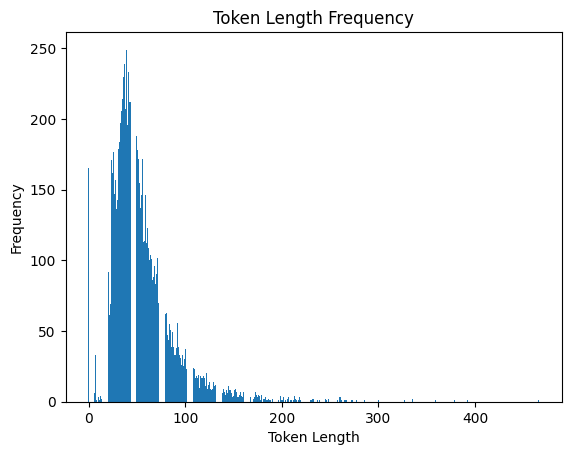

In [67]:
token_text= []
token_len = []

for data_point in text_list:
    text = data_point[3]

    # Tokenize the subject, object, and text using BERT tokenizer
    tokenized_text = tokenizer.tokenize(text)
    token_text.append(tokenized_text)
    token_len.append(len(tokenized_text))

# Count the frequency of each text length
token_length_freq = Counter(token_len)

# Extract lengths and frequencies for plotting
lengths = list(token_length_freq.keys())
frequencies = list(token_length_freq.values())

# Plotting
plt.bar(lengths, frequencies)
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Token Length Frequency')
plt.show()


In [68]:
# Define your max sequence length
max_seq_length = 128

inputs_text = []
labels = []

for data_point in text_list:
    text = data_point[3]

    tokenized_text = tokenizer.tokenize(text)
    tokenized_text = tokenized_text[:max_seq_length - 2]
    tokenized_text = ['[CLS]'] + tokenized_text + ['[SEP]']
    paded_text = pad_sequences(tokenized_text, max_seq_length)

    # Convert the tokenized subject, object, and text to input IDs
    input_ids_text = tokenizer.convert_tokens_to_ids(paded_text)
    inputs_text.append(input_ids_text)

    # Label the relevant entities and their relationships
    label = data_point[4]
    labels.append(label)


In [69]:
inputs_tns = torch.tensor(inputs_text)
labels_tns = torch.tensor(labels)

# Split the data into training, validation, and test sets
train_input, val_input, train_labels, val_labels = train_test_split(inputs_tns, labels_tns, test_size=0.3,stratify= labels ,random_state=42)
val_input, test_input, val_labels, test_labels = train_test_split(val_input, val_labels, test_size=0.5, random_state=42)


In [70]:
# Create a TensorDataset from the input tensors and labels
train_dataset = TensorDataset(train_input, train_labels)

val_dataset = TensorDataset(val_input, val_labels)

test_dataset = TensorDataset(test_input, test_labels)

# Define batch size and create DataLoader instances
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [71]:
model_bert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Optional: Freeze BERT layers if desired
for param in model_bert.base_model.parameters():
    param.requires_grad = False

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)

# Wrap the model with DataParallel
if torch.cuda.device_count() > 1:
    model_bert = torch.nn.DataParallel(model_bert)

# print(model_bert)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
# Step 5: Fine-tune the BERT model

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model_bert.parameters(), lr=3e-5)
num_epochs = 50
scaler = GradScaler()

# Create an array to save train and validation loss (will be used in the plot)
train_loss_array = []
val_loss_array = []

# Training loop
for epoch in range(num_epochs):
    model_bert.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        inputs_text, labels = batch
        inputs_text, labels = inputs_text.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model_bert(inputs_text, labels= labels)
            logits = outputs.logits

            # Use the Focal Loss function here
            loss = loss_fn(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = total_loss / len(train_dataloader)

    # Validation loop
    model_bert.eval()
    val_loss = 0
    num_val_steps = 0

    with torch.no_grad():
        for batch in val_dataloader:
            inputs_text,  labels = batch
            inputs_text, labels = inputs_text.to(device), labels.to(device)

            outputs = model_bert(inputs_text)
            logits = outputs.logits

            loss = loss_fn(logits, labels)
            val_loss += loss.item()
            num_val_steps += 1

    avg_val_loss = val_loss / num_val_steps

    if epoch % 5 ==0:
      print(f"Epoch {epoch}/{num_epochs}, Train_Loss: {avg_train_loss:.4f}, Val_Loss: {avg_val_loss:.4f}")

    train_loss_array.append(avg_train_loss)
    val_loss_array.append(avg_val_loss)


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-72-c4f85286d0c0>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-72-c4f85286d0c0>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 0/50, Train_Loss: 1.5431, Val_Loss: 1.4415
Epoch 5/50, Train_Loss: 0.9816, Val_Loss: 0.9048
Epoch 10/50, Train_Loss: 0.8150, Val_Loss: 0.7584
Epoch 15/50, Train_Loss: 0.7425, Val_Loss: 0.6881
Epoch 20/50, Train_Loss: 0.6972, Val_Loss: 0.6476
Epoch 25/50, Train_Loss: 0.6636, Val_Loss: 0.6183
Epoch 30/50, Train_Loss: 0.6390, Val_Loss: 0.5977
Epoch 35/50, Train_Loss: 0.6181, Val_Loss: 0.5801
Epoch 40/50, Train_Loss: 0.6041, Val_Loss: 0.5656
Epoch 45/50, Train_Loss: 0.5861, Val_Loss: 0.5506


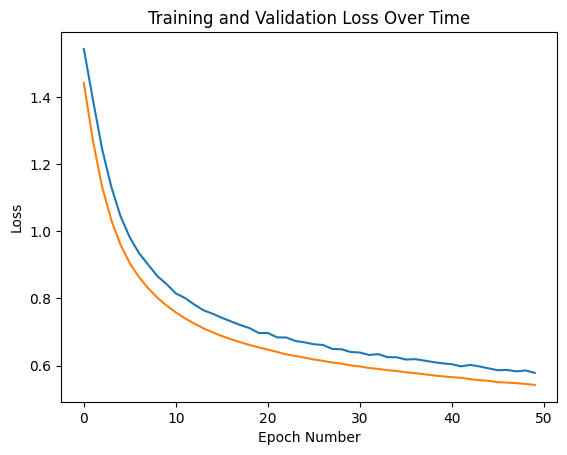

In [73]:
plt.plot(train_loss_array)
plt.plot(val_loss_array)
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()


In [74]:
def compute_accuracy(predictions, labels):
    predicted_labels = torch.argmax(predictions, dim=1)
    correct_predictions = torch.eq(predicted_labels, labels).sum().item()
    accuracy = correct_predictions / len(labels)
    return accuracy



In [75]:
# evaluate the model by computing  accuracy, precision, recall, and F1-score
model_bert.eval()
val_accuracy = 0
num_val_steps = 0

with torch.no_grad():
    for batch in val_dataloader:
        inputs_text, labels = batch
        inputs_text, labels = inputs_text.to(device), labels.to(device)

        outputs = model_bert(inputs_text)
        val_accuracy += compute_accuracy(outputs.logits, labels)
        num_val_steps += 1

avg_val_accuracy = val_accuracy / num_val_steps

print(f"Validation Accuracy: {avg_val_accuracy:.4f}")


Validation Accuracy: 0.7943


In [76]:
# Evaluation loop
model_bert.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs_text, labels = batch
        inputs_text, labels = inputs_text.to(device), labels.to(device)

        outputs = model_bert(inputs_text)
        predicted_labels = torch.argmax(outputs.logits, dim=1)

        predictions.extend(predicted_labels.tolist())
        true_labels.extend(labels.tolist())


In [77]:
# Classification report
print(classification_report(true_labels, predictions))


              precision    recall  f1-score   support

           0       0.76      0.75      0.76       368
           1       0.93      0.90      0.91       318
           2       0.67      0.63      0.65       307
           3       0.70      0.76      0.73       347
           4       0.88      0.91      0.89       310

    accuracy                           0.79      1650
   macro avg       0.79      0.79      0.79      1650
weighted avg       0.79      0.79      0.79      1650



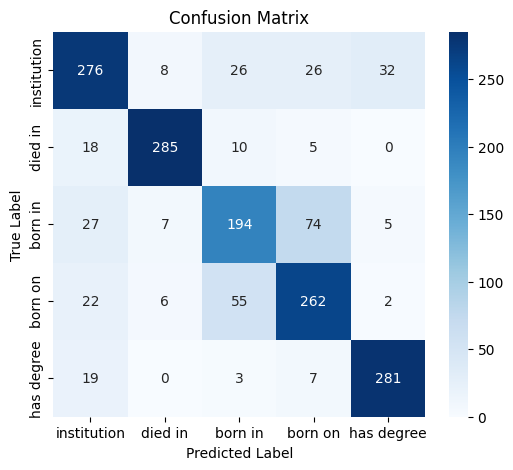

In [78]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['institution', 'died in', 'born in', 'born on', 'has degree'], yticklabels=['institution', 'died in', 'born in', 'born on', 'has degree'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()